In [1]:
# Importing packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Data Understanding

In [2]:
player = pd.read_excel('player_details.xlsx')

In [3]:
matches = pd.read_excel('match_cleaned.xlsx')

In [4]:
matches.head()

,match_id,match_name,date,start_time,gmtoffset,winning_team,toss_winner,venue,toss_choice,toss_direction,winning_score,loosing_score
0,1,Match 1,7/26/2014,20:00,+05:30,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31
1,2,Match 2,7/26/2014,21:00,+05:30,Bengaluru Bulls,Dabang Delhi K.C.,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Left,47,28
2,3,Match 3,7/27/2014,20:00,+05:30,Bengaluru Bulls,Bengaluru Bulls,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,40,37
3,4,Match 4,7/27/2014,21:00,+05:30,U Mumba,Bengal Warriors,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Left,36,25
4,5,Match 5,7/28/2014,20:00,+05:30,Dabang Delhi K.C.,Puneri Paltan,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,35,31


### Matches Data preparation

In [5]:
matches['Year'] = matches['date'].apply(lambda x : x[-4:])
matches['Year'] = matches['Year'].astype('int')

In [6]:
matches['Month'] = matches['date'].apply(lambda x : x[:x.find('/')])
matches['Month'] = matches['Month'].apply(lambda x : x[:x.find('-')] if len(x) > 1 else x)
matches['Month'] = matches['Month'].astype('int')

In [7]:
matches['Season'] = matches['Year'].map({2014:'Season 1',2015:'Season 2',2016:'Season 34',2017:'Season 5',2018:'Season 6',2019:'Season 7'})

In [8]:
for i in range(0,len(matches)):
    if (matches.loc[i,'Season'] == 'Season 34') and (matches.loc[i,'Month'] < 6):
        matches.loc[i,'Season'] = 'Season 3'
    elif matches.loc[i,'Season'] == 'Season 34':
        matches.loc[i,'Season'] = 'Season 4'

In [9]:
matches = matches[matches['toss_winner'].isin(['U Mumba', 'Dabang Delhi K.C.', 'Bengaluru Bulls',
       'Bengal Warriors', 'Puneri Paltan', 'Telugu Titans',
       'Jaipur Pink Panthers', 'Patna Pirates','Haryana Steelers', 'Gujarat Fortunegiants', 'U.P. Yoddha',
       'Tamil Thalaivas'])]

In [10]:
matches['winning_score'] = matches['winning_score'].apply(lambda x : 0 if x in ['Match Tie','N'] else int(x))

In [11]:
matches['loosing_score'] = matches['loosing_score'].apply(lambda x : 0 if x in ['Match Tie','N'] else int(x))

In [12]:
match_detail = matches.drop(['match_name','gmtoffset'],axis=1)

In [13]:
player_detail = player.drop(['skill','role','jersey'],axis=1)

In [14]:
match_detail['winning_team'].fillna('DRAW',inplace=True)

### Player Data with match details

In [15]:
player_detail = player_detail.merge(match_detail,on='match_id',how='left')

In [16]:
player_detail.isnull().sum()

match_id                           0
Team                               0
id                                 0
name                               0
short_name                     15791
red_card                           0
yellow_card                        0
green_card                         0
played                             0
captain                            0
on_court                           0
starter                            0
top_raider                         0
top_defender                       0
Player_points_total                0
raider_points_total                0
raider_points_touch                0
raider_points_raid_bonus           0
tackle_points_total                0
tackle_points_capture              0
tackle_points_capture_bonus        0
raids_total                        0
raids_successful                   0
raids_unsuccessful                 0
raids_Empty                        0
raids_total.1                      0
raids_successful.1                 0
r

In [17]:
player_detail.drop(player_detail[player_detail['start_time'].isnull()].index,inplace=True)

In [18]:
player_detail.shape

(15460, 44)

In [19]:
player_detail.to_excel('player_cleaned_data.xlsx',index=False)

### Data Preparation

In [20]:
#player_detail.drop(['match_id','date','temp'],axis=1,inplace=True)
player_detail.drop(['match_id','date'],axis=1,inplace=True)

In [21]:
for each in ['red_card','yellow_card','green_card','played','captain','on_court','starter','top_raider',
            'top_defender','toss_direction','toss_choice']:
    
    freq = player_detail[each].mode()[0]
    player_detail[each] = player_detail[each].apply(lambda x : 1 if x == freq else 0)

In [22]:
player_detail['start_time'].unique()

array(['20:00', '21:00', '21:15', '19:30', '20:30'], dtype=object)

In [23]:
player_detail['raider_sucess_%'] = player_detail['raids_successful']/ player_detail['raids_total'] * 100

In [24]:
player_detail.drop(['raids_successful','raids_total'],axis=1,inplace=True)

In [25]:
player_detail['tackle_sucess_%'] = player_detail['tackles_successful']/ player_detail['tackles_total'] * 100

In [26]:
player_detail.drop(['tackles_successful','tackles_total'],axis=1,inplace=True)

In [27]:
player_detail['raider_sucess_%'].fillna(0,inplace=True)
player_detail['tackle_sucess_%'].fillna(0,inplace=True)

In [28]:
player_detail[['start_time','raider_sucess_%']].groupby('start_time').describe(percentiles=[.25,.5,.75,.9,.95,.99])

raider_sucess_%                                                  \
                     count       mean        std  min  25%  50%        75%   
start_time                                                                   
19:30               1459.0  11.131878  20.164083  0.0  0.0  0.0  20.000000   
20:00               7077.0  11.947603  21.308876  0.0  0.0  0.0  20.000000   
20:30               1222.0  11.604431  21.101383  0.0  0.0  0.0  20.000000   
21:00               5678.0  12.195719  21.648886  0.0  0.0  0.0  21.428571   
21:15                 24.0   8.469043  16.553768  0.0  0.0  0.0   3.125000   

                                                          
                  90%        95%         99%         max  
start_time                                                
19:30       42.857143  50.217391   77.777778  100.000000  
20:00       45.454545  55.555556  100.000000  100.000000  
20:30       45.454545  54.545455  100.000000  100.000000  
21:00       45.454545  54.545455  100.000000  100.000000  
21:15       37.000000  45.230769   50.948718   52.380952

In [29]:
def group_time(x):
    if x == '19:30':
        return 'Early'
    elif x=='21:15':
        return 'Late'
    else:
        return 'Ususal'

player_detail['start_time'] = player_detail['start_time'].apply(lambda x : group_time(x))

In [30]:
player_detail.index = range(0,len(player_detail))

In [31]:
for i in range(0,len(player_detail)):
    if player_detail.loc[i,'Team'] in player_detail.loc[i,'winning_team'].upper():
        player_detail.loc[i,'winning_team'] = 1
    else:
        player_detail.loc[i,'winning_team'] = 0

In [32]:
for i in range(0,len(player_detail)):
    if player_detail.loc[i,'Team'] in player_detail.loc[i,'toss_winner'].upper():
        player_detail.loc[i,'toss_winner'] = 1
    else:
        player_detail.loc[i,'toss_winner'] = 0

In [33]:
player_detail.shape

(15460, 40)

In [34]:
raids = player_detail

In [35]:
player_id = raids['id']
player_name = raids['name']
player_short_name = raids['short_name']

In [36]:
raids.columns

Index(['Team', 'id', 'name', 'short_name', 'red_card', 'yellow_card',
       'green_card', 'played', 'captain', 'on_court', 'starter', 'top_raider',
       'top_defender', 'Player_points_total', 'raider_points_total',
       'raider_points_touch', 'raider_points_raid_bonus',
       'tackle_points_total', 'tackle_points_capture',
       'tackle_points_capture_bonus', 'raids_unsuccessful', 'raids_Empty',
       'raids_total.1', 'raids_successful.1', 'raids_unsuccessful.1',
       'raids_Empty.1', 'tackles_unsuccessful', 'start_time', 'winning_team',
       'toss_winner', 'venue', 'toss_choice', 'toss_direction',
       'winning_score', 'loosing_score', 'Year', 'Month', 'Season',
       'raider_sucess_%', 'tackle_sucess_%'],
      dtype='object')

In [37]:
raids.drop(['Team','id','name','short_name'],axis=1,inplace=True)

In [38]:
raids.columns

Index(['red_card', 'yellow_card', 'green_card', 'played', 'captain',
       'on_court', 'starter', 'top_raider', 'top_defender',
       'Player_points_total', 'raider_points_total', 'raider_points_touch',
       'raider_points_raid_bonus', 'tackle_points_total',
       'tackle_points_capture', 'tackle_points_capture_bonus',
       'raids_unsuccessful', 'raids_Empty', 'raids_total.1',
       'raids_successful.1', 'raids_unsuccessful.1', 'raids_Empty.1',
       'tackles_unsuccessful', 'start_time', 'winning_team', 'toss_winner',
       'venue', 'toss_choice', 'toss_direction', 'winning_score',
       'loosing_score', 'Year', 'Month', 'Season', 'raider_sucess_%',
       'tackle_sucess_%'],
      dtype='object')

In [39]:
raids['Season'] = raids['Season'].astype('category')
raids['venue'] = raids['venue'].astype('category')

### Data Preparation

In [40]:
cat = pd.get_dummies(raids.select_dtypes(include='object'))

In [41]:
raids_model = pd.concat([cat,raids.select_dtypes(exclude='object')],axis=1)

In [42]:
raids_model.shape

(15460, 38)

In [43]:
raids_train = raids_model[raids_model['Season'] != 'Season 7']

In [44]:
raids_train.shape

(12731, 38)

In [45]:
raids_test = raids_model[raids_model['Season'] == 'Season 7']

In [46]:
raids_test.shape

(2729, 38)

In [47]:
X_train = raids_train.drop(['raider_sucess_%','Season','raider_points_total','venue'],axis=1)
y_train = raids_train['raider_sucess_%']

In [48]:
X_train.shape

(12731, 34)

In [49]:
y_train.shape

(12731,)

In [50]:
X_test = raids_test.drop(['raider_sucess_%','Season','raider_points_total','venue'],axis=1)
y_test = raids_test['raider_sucess_%']

In [51]:
X_test.shape

(2729, 34)

In [52]:
y_test.shape

(2729,)

In [53]:
# scaling the features


# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)

scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

In [54]:
X_test[X_train.columns] = scaler.transform(X_test[X_train.columns])

### Model

In [55]:
params = {'alpha': [0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,5,10,50,100,200,500]}

In [56]:
lasso = Lasso()

# cross validation
folds=5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    3.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1, 5, 10, 50, 100, 200,
                                   500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [57]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.227688,0.019434,0.001596,0.000489,0.01,{'alpha': 0.01},-7.779091,-8.817898,-8.107720,-7.862420,...,-7.914319,0.583515,7,-7.594038,-7.713888,-7.858657,-7.817440,-7.919690,-7.780743,0.114936
1,0.129548,0.017250,0.000798,0.000746,0.02,{'alpha': 0.02},-7.756053,-8.797335,-8.127608,-7.857209,...,-7.904878,0.585539,6,-7.592631,-7.709160,-7.853609,-7.810314,-7.917981,-7.776739,0.114410
2,0.069006,0.010239,0.003330,0.006173,0.05,{'alpha': 0.05},-7.688835,-8.738852,-8.191864,-7.841971,...,-7.880646,0.592115,5,-7.585714,-7.697463,-7.841627,-7.793409,-7.915254,-7.766693,0.114844
3,0.040610,0.007649,0.000000,0.000000,0.1,{'alpha': 0.1},-7.574140,-8.646891,-8.278394,-7.831598,...,-7.843189,0.604288,4,-7.590366,-7.682769,-7.827433,-7.776983,-7.914969,-7.758504,0.112765
4,0.024223,0.008065,0.000199,0.000399,0.2,{'alpha': 0.2},-7.622938,-8.481551,-8.257501,-7.827167,...,-7.797076,0.585351,1,-7.622552,-7.672375,-7.790697,-7.760643,-7.901746,-7.749602,0.097020


In [58]:
cv_results[['param_alpha','mean_train_score','mean_test_score']]

,param_alpha,mean_train_score,mean_test_score
0,0.01,-7.780743,-7.914319
1,0.02,-7.776739,-7.904878
2,0.05,-7.766693,-7.880646
3,0.1,-7.758504,-7.843189
4,0.2,-7.749602,-7.797076
5,0.3,-7.762082,-7.797354
6,0.4,-7.795193,-7.840463
7,0.5,-7.842503,-7.929325
8,0.6,-7.900265,-8.030047
9,0.7,-7.969144,-8.132760


In [59]:
alpha = 0.2

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
lasso.score(X_train,y_train)

0.5637384237551497

In [61]:
y_predict = lasso.predict(X_test)

In [62]:
print(r2_score(y_test,y_predict))

0.6126144545837401


In [63]:
print(r2_score(y_test,y_predict))
print(np.sqrt(mean_squared_error(y_test,y_predict)))

0.6126144545837401
12.88446231294909


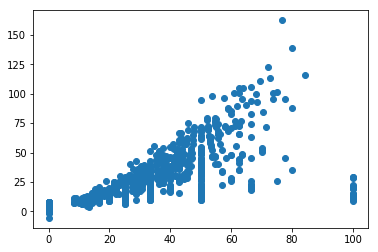

In [64]:
plt.scatter(y_test,y_predict)

In [65]:
features = np.abs(pd.Series(dict(zip(X_train.columns,lasso.coef_)))).sort_values(ascending=False)

In [66]:
features

raids_successful.1             1.538099e+01
top_raider                     2.191359e+00
raider_points_touch            1.683047e+00
played                         1.542698e+00
raids_Empty.1                  1.533312e+00
on_court                       1.224426e+00
raider_points_raid_bonus       1.196157e+00
captain                        7.510621e-01
Year                           3.620499e-01
starter                        3.396574e-01
tackle_points_capture          1.957135e-01
toss_direction                 4.988260e-02
start_time_Late                3.146326e-02
red_card                       8.830752e-04
start_time_Ususal              2.393219e-15
yellow_card                    0.000000e+00
green_card                     0.000000e+00
top_defender                   0.000000e+00
Player_points_total            0.000000e+00
tackle_sucess_%                0.000000e+00
tackle_points_total            0.000000e+00
Month                          0.000000e+00
tackle_points_capture_bonus    0

In [67]:
raiders = pd.DataFrame(np.array([player_name.loc[raids_test.index].values,y_predict]).T,columns=['Playername','Predicted sucessful raid %'])

In [68]:
raiders['Predicted sucessful raid %'] = raiders['Predicted sucessful raid %'].astype('float')
raiders = raiders[['Playername','Predicted sucessful raid %']].groupby('Playername').mean().sort_values(by='Predicted sucessful raid %',ascending=False)

In [69]:
raiders.head()

,Predicted sucessful raid %
Playername,
Pawan Sehrawat,73.226937
Naveen Kumar,71.961245
Pardeep Narwal,66.212563
Sachin,57.723779
Maninder Singh,57.568298
